In [1]:
'''
This notebook should stay in root directory
'''
# The directory of the data is "data_specific_enzymes/databases/tsvs"
# The data are in tsv format

import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

#seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
def load_data(directory, name):
    """
    Load the data from the directory
    """
    dataframe = pd.read_csv(directory, sep = "\t")
    
    #dataframe = dataframe.dropna(subset = ["EC number"]) #drop rows with missing EC number
    print("check sequences: ", len(dataframe))
    dataframe = dataframe.dropna(subset = ["Sequence"]) 
    dataframe = dataframe.dropna(subset = ["Protein existence"])
    print("check sequences after: ", len(dataframe))
    
    print("The following data regard the family with EC number: ", name[-1])

    dictionary_existence = {"Evidence at protein level": 5, "Evidence at transcript level": 4, "Inferred from homology": 3, "Predicted": 2, "Uncertain": 1}
    dataframe["Protein existence"] = dataframe["Protein existence"].str.strip().map(dictionary_existence)
    dataframe["Sequence"] = dataframe["Sequence"].apply(str)

    #keep only such columns
    dataframe = dataframe[["Entry","EC number", "Protein existence", "Sequence", "Length", 'Gene Ontology (molecular function)']]

    print("The number of sequences before removing duplicates is: ", len(dataframe))
    before = len(dataframe)
    # Sort the DataFrame by 'Sequence' for grouping and 'Protein existence' descending to have the highest on top
    dataframe = dataframe.sort_values(by=['Sequence', 'Protein existence'], ascending=[True, False])
    # Drop duplicates based on the 'Sequence' column, keeping the first entry (the one with the highest 'Existence level') for each sequence
    dataframe = dataframe.drop_duplicates(subset=['Sequence'], keep='first')
    print("The number of sequences after removing duplicates is: ", len(dataframe), 'duplicates: ', before - len(dataframe))

    # per non modificare sampling stratificato con EC numbers: voglio definire un EC number per ogni Gene Ontology (molecular function),
    # poi le filtrerà dopo se sono poche e farà sampling relativamente e queste keywords!
    
    # TODO CODE
    
    '''
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [0] + x) #put 0 at the beginning of the list
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: list(set(x))) #for each y take only the unique values
    '''
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [0])
    
    #count EC numbers
    ec_numbers = []
    for i in dataframe["EC number"]:
        ec_numbers += i
    values, counts = np.unique(np.array(ec_numbers), return_counts = True)
    counts_dict = dict(zip(values, counts))
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [y for y in x if counts_dict[y] > 100]) #take only EC numbers with more than 100 proteins
    sorted_list = sorted([int(x) for x in counts_dict.keys() if counts_dict[x] > 100])
    mapping_dict = dict(zip(sorted_list, range(len(sorted_list))))
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [mapping_dict[y] for y in x]) #map the EC numbers to a range of their length
    print("The number of sequences per subfamily is: ", counts_dict)
    print("The dictionary to map subfamily to keyword:", mapping_dict)
    mean_length = dataframe["Length"].mean()
    std_length = dataframe["Length"].std()
    print("The mean length of the sequences is: ", round(mean_length, 3))
    print("The standard deviation of the length of the sequences is: ", round(std_length, 3))
    return dataframe, mapping_dict



In [3]:
def plot_histogram(path, data, bin_step, name):
    """
    Plot and save the histogram of the lengths of the sequences
    """
    # Create the histogram
    max_val = max(data)
    bin_edges = list(range(0, 500, bin_step))
    #print(bin_edges)
    plt.figure(figsize=(11, 6))
    n, bins, _ = plt.hist(data, bins=bin_edges, color=(180/255, 211/255, 178/255), edgecolor='black', alpha=0.99, rwidth=0.87)    
    print("n:", n)
    print("bins:", bins)
    # Title, labels, and legend
    plt.title('Histogram of Sequence Length Ranges for EC ' + name[-1])
    plt.xlabel('Sequence Length')
    plt.ylabel('Number of Instances')
    #plt.legend()
    _ = plt.show()
    plt.savefig(path+"histogram_"+name+'.svg')

In [4]:

def split_train_test_validation(dataframe, train_fraction, validation_fraction, mapping_dict, seed=None):
    # Split the dataframe into training, validation, and test sets
    dataframe["subfamily"] = dataframe["EC number"].apply(lambda x: x[-1])
    train_dataframes = []
    validation_dataframes = []
    test_dataframes = []
    for i in mapping_dict.values():
        sub_dataframe = dataframe[dataframe["subfamily"] == i]
        train_dataframe = sub_dataframe.sample(frac=train_fraction, random_state=seed)
        remaining_dataframe = sub_dataframe.drop(train_dataframe.index)
        validation_fraction_adjusted = validation_fraction / (1 - train_fraction)  # Adjusting fraction based on remaining data
        validation_dataframe = remaining_dataframe.sample(frac=validation_fraction_adjusted, random_state=seed)
        test_dataframe = remaining_dataframe.drop(validation_dataframe.index)
        train_dataframes.append(train_dataframe)
        validation_dataframes.append(validation_dataframe)
        test_dataframes.append(test_dataframe)
    
    train = pd.concat(train_dataframes).drop(columns=["subfamily"])
    validation = pd.concat(validation_dataframes).drop(columns=["subfamily"])
    test = pd.concat(test_dataframes).drop(columns=["subfamily"])
    return train, validation, test


def convert_to_dict(dataframe):
    #convert the dataframes to dictionaries
    dictionary = {}
    for _, row in dataframe.iterrows():
        sub_dict = {}
        sub_dict["kw"] = row["EC number"]
        sub_dict["ex"] = row["Protein existence"]
        sub_dict["seq"] = row["Sequence"]
        sub_dict["len"] = row["Length"]
        sub_dict['GO_molecular_function'] = row['Gene Ontology (molecular function)']
        dictionary[row["Entry"]] = sub_dict
    # convert the dictionary items to a list, shuffle the list, and convert it back to a dictionary
    items = list(dictionary.items())
    random.shuffle(items)
    return dict(items)

def save_to_pickle(dictionary, path):
    #save the dictionary to a pickle file
    with open(path, "wb") as file:
        pickle.dump(dictionary, file)

In [5]:
os.listdir('data_specific_enzymes/databases/tsvs/')

['uniprotkb_ec_5_4_99_5_AND_length_10_TO_2024_03_26.tsv',
 'uniprotkb_ec_4_1_1_39_AND_length_10_TO_2024_04_02.tsv',
 'uniprotkb_ec_1_1_1_1_AND_length_0_TO_50_2024_04_02-2.tsv',
 'uniprotkb_ec_6_3_4_15_AND_length_10_TO_2024_04_02.tsv',
 'uniprotkb_ec_3_2_1_4_AND_length_10_TO_5_2024_04_29.tsv',
 '.ipynb_checkpoints',
 'uniprotkb_ec_7_2_1_1_AND_length_10_TO_5_2024_04_02.tsv',
 'uniprotkb_ec_2_1_1_37_AND_length_10_TO_2024_03_28.tsv']

check sequences:  30548
check sequences after:  30548
The following data regard the family with EC number:  4
The number of sequences before removing duplicates is:  30548
The number of sequences after removing duplicates is:  28768 duplicates:  1780
The number of sequences per subfamily is:  {0: 28768}
The dictionary to map subfamily to keyword: {0: 0}
The mean length of the sequences is:  334.245
The standard deviation of the length of the sequences is:  106.053
n: [  44.  576. 1219. 1146. 4223. 2661. 4986. 5513. 3652.]
bins: [  0.  50. 100. 150. 200. 250. 300. 350. 400. 450.]


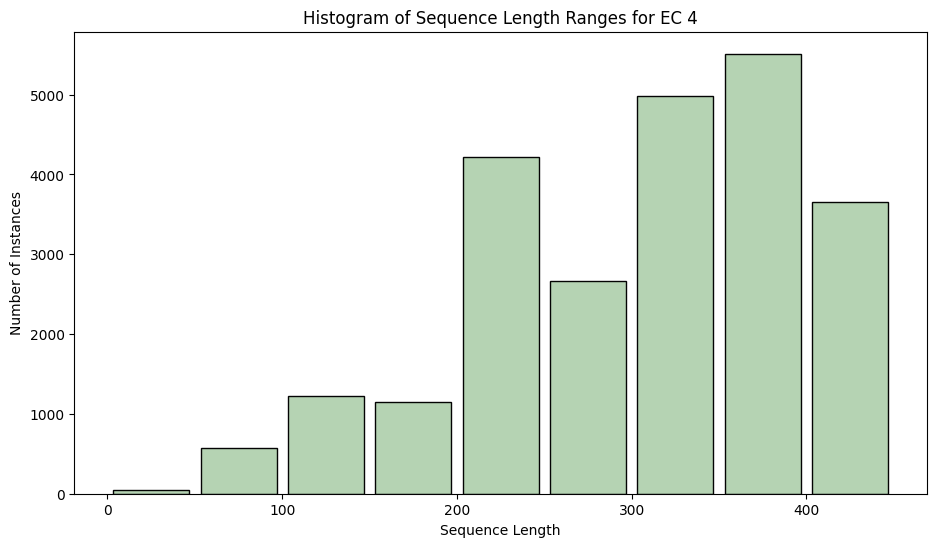

<Figure size 640x480 with 0 Axes>

In [9]:
# data_specific_enzymes/databases/tsvs/name.tsv
directory = "data_specific_enzymes/databases/tsvs/uniprotkb_ec_3_2_1_4_AND_length_10_TO_5_2024_04_29.tsv"
name = "ec_3_2_1_4"
dataframe, mapping_dict = load_data(directory, name=name)

path_hist = "data_specific_enzymes/databases/tmp/"
_ = plot_histogram(path_hist, dataframe["Length"].to_numpy(), 50, name)

#split the dataframes into training, validation, and test sets for each EC number 90% training, 5% test, 5% validation
train_fraction = 0.9
validation_fraction = 0.05
training, validation, test = split_train_test_validation(dataframe, train_fraction, validation_fraction, mapping_dict, SEED)

#convert the dataframes to dictionaries
training = convert_to_dict(training)
test = convert_to_dict(test)
validation = convert_to_dict(validation)

#save the dictionaries to pickle files
save_to_pickle(training, "data_specific_enzymes/databases/pickles/training_"+name+ ".p")
save_to_pickle(test, "data_specific_enzymes/databases/pickles/test_"+name+ ".p")
save_to_pickle(validation, "data_specific_enzymes/databases/pickles/validation_"+name+ ".p")


In [10]:
import pickle
with open("data_specific_enzymes/databases/pickles/training_"+name+ ".p", "rb") as file:
    training = pickle.load(file)
keys = list(training.keys())
for key in keys[:10]:
    print(key, training[key])

A0A2X3KIJ3 {'kw': [0], 'ex': 3, 'seq': 'MNLEQKLQKLSDAFGVAGFEDEAREVLHGMVSPYVESCETDTLGNLTCSRGSGDAVMLDAHMDEVGFMVKWIEKDGFLRLTALGGWDDRILMAHRLTILTRSGEKVHGVIGSTPPHIQSDGDRDKVVPLDDLFVDIGARSRDEAEAFGVHIGDPATIHYPFLRLQEGYVTGKAFDDRAGCLVAAEALRILAKEKLPYKLVVNFAVHEEGGLRGAKAAAYRVAPKLALALEGTIGADMPGVPEAKQPVRLGHGPAITLADRSITVKPKLARFLEKIADENGISYQYKLPAYGSTDAGAIHLERGGILTGVVSVPCRYIHSPVSTLYLADLEATLDLVVAFLRRAGELL', 'len': 347, 'GO_molecular_function': 'aminopeptidase activity [GO:0004177]; cellulase activity [GO:0008810]; metal ion binding [GO:0046872]'}
A0A495X1I6 {'kw': [0], 'ex': 3, 'seq': 'MKRSTVVLAACLLAAGSAAALLPHAMAAAQGCRVDYTVSSQWQGGFQAGVKVTNLGDPVSGWTLAFSFPNTGQKLTQGWNATWSQSGSTVTAASLEWNRSLGTGASVDLGFTGSWSGANPVPTAFTLNGVACTGTPVTTTTTTTTTTGNPPVGRTPVEINGQLRVCGVNLCNQYNRPIQLRGMSTHGIQWFDKCYNSASLDALANDWKADLLRIAMYVQEQGYETNPSGFTSRVNSLVDMAEARGLYAIIDFHTLTPGDPNYNLDRAKTFFSQVASRNAAKKNVIYEIANEPNGVSWAGIKSYAEQVIPVIRAADPDAVVLVGTRGWSSLGVSDGSNESEIVNNPVNATNIMYTFHFYAASHKDNYRSTVSRAATRLPLFVSEFGTVSATGGGAYDQSSSTAWLDLLDQLKISYANWTYSDADESSAA

In [11]:
import pickle
import os
import subprocess
def save_to_fasta(path_to_load, path_to_save):
    name = path_to_load.split("/")[-1].split(".")[0]
    with open(path_to_load, "rb") as file:
        data = pickle.load(file)
    with open(path_to_save + name + ".fasta", "w") as f:
        for seq_id, seq_info in data.items():
            f.write(f">{seq_id}\n{seq_info['seq']}\n")
print(name)

pickle_path = "data_specific_enzymes/databases/pickles/training_"+name+ ".p"
output_path = "data_specific_enzymes/databases/fasta/training_"+name+ ".fasta"
save_to_fasta(pickle_path, output_path)

pickle_path = "data_specific_enzymes/databases/pickles/test_"+name+ ".p"
output_path = "data_specific_enzymes/databases/fasta/test_"+name+ ".fasta"
save_to_fasta(pickle_path, output_path)

pickle_path = "data_specific_enzymes/databases/pickles/validation_"+name+ ".p"
output_path = "data_specific_enzymes/databases/fasta/validation_"+name+ ".fasta"
save_to_fasta(pickle_path, output_path)


ec_3_2_1_4
